In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
from collections import defaultdict
os.chdir('..')
os.chdir('src')
from env import BlackjackEnv


### Parsing the necessary files

In [2]:
def parse_strategy_csv(file_path):
    try:
        # Read the CSV file
        df = pl.read_csv(file_path)
        
        # Initialize the basic strategy dictionary
        strategy = {}
        
        # Process the dataframe into a dictionary
        for row in df.iter_rows(named=True):
            # Parse the state from string format like '(12, 10, 0)'
            # Extract the state values
            state_str = row['State'].strip('()').split(', ')

            # state_str = row['State'].strip('[]').split()
            player_sum = int(state_str[0])
            dealer_card = int(state_str[1])
            usable_ace = int(state_str[2])
            
            # Create the state key
            state_key = (player_sum, dealer_card, usable_ace)
            
            # Get the action values
            stand_value = row['Action 0 (Stand)']
            hit_value = row['Action 1 (Hit)']
            # Check if the column for double action exists
            if 'Action 2 (Double)' in row:
                double_value = row['Action 2 (Double)']
            else:
                # If not present, set double value to None or some default
                double_value = None
            
            # Store the action values in a dictionary
            strategy[state_key] = {
                0: stand_value,  # Stand
                1: hit_value,    # Hit
                2: double_value   # Double
            }
            
        return strategy
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return {}

In [3]:
# Function to parse betting strategy
def parse_betting_strategy_csv(file_path):
    """
    Parse a CSV file containing a betting strategy table.
    Returns a dictionary with true count keys and bet values.
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Initialize the betting strategy dictionary
        betting_strategy = {}
        
        # Process the dataframe into a dictionary
        for _, row in df.iterrows():
            true_count = int(row['true_count'])
            
            # Get the bet values for each true count
            bet_values = {}
            for bet in [1, 4, 8]:  # Assuming these are the possible bet sizes
                if f"{bet}" in df.columns:
                    bet_values[bet] = row[f"{bet}"]
            
            betting_strategy[true_count] = bet_values
            
        return betting_strategy
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return {}

In [4]:
def parse_split_strategy_csv(file_path):
    """
    Parse a CSV file containing a split strategy table.
    Returns a dictionary with state keys and split values.
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Initialize the split strategy dictionary
        split_strategy = {}
        
        # Process the dataframe into a dictionary
        for _, row in df.iterrows():
            # Extract the state key
            pair_value = int(row['Pair Value'])
            dealer_upcard = int(row['Dealer Upcard'])
            state_key = (pair_value, dealer_upcard)
            
            # Get the split and no-split values
            split_value = row['Split']
            no_split_value = row['No Split']
            
            # Store the values in the dictionary
            split_strategy[state_key] = {
                0: no_split_value,  # No Split
                1: split_value      # Split
            }
            
        return split_strategy
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return {}

In [5]:
os.chdir('..')
os.chdir('strategies')
# Load the playing and betting strategies
basic_strat = parse_strategy_csv('basic_strat_doub.csv')
betting_strat = parse_betting_strategy_csv('q_table_bet_avg.csv')
dd_strat = parse_strategy_csv('dq_h_s_dd_strat.csv')
basic_split_strat = parse_split_strategy_csv('basic_split_strat.csv')

### Q-table initialization for splitting

In [6]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1, 4, 8],
    "actions": ["stand", "hit", "double", "split"],
    "num_players": 1,
    "max_splits": 3,
    "split_aces_only_one_card": True
}

env = BlackjackEnv(config)

In [7]:
# Initialize Q-tables for splitting strategy
q_table_split_1 = {}
q_table_split_2 = {}

# For each possible pair (2-9, T, A) and dealer upcard (2-10, A)
for pair_value in range(2, 12):  # 2-10, 11 (Ace)
    for dealer_upcard in range(2, 12):  # 2-10, 11 (Ace)
        # Create a state key for the pair
        state_key = (pair_value, dealer_upcard)
        
        # Initialize Q-values for split vs. no-split
        # We'll use 0 for "don't split" and 1 for "split"
        q_table_split_1[state_key] = {0: -0.1, 1: -0.1}  # 0=don't split, 1=split
        q_table_split_2[state_key] = {0: -0.1, 1: -0.1}  # 0=don't split, 1=split

# State visit tracking for exploration bias
state_visits = {state_key: 0 for state_key in q_table_split_1.keys()}

### Hyperparameters

In [8]:
### Hyperparameters
initial_alpha = 0.1      # Starting learning rate
min_alpha = 0.01        # Minimum learning rate
decay_rate = 0.999997    # Decay rate for learning rate
gamma = 1.0             # Discount factor
starting_epsilon = 1.0   # Exploration rate
epsilon_decay = 0.999995  # Decay rate for exploration
min_epsilon = 0.01       # Minimum exploration rate

### Auxiliary functions

In [9]:
def discretize_true_count(tc):
    """Convert true count to a discrete bucket for betting decisions"""
    if tc <= 1: 
        return 0
    elif 1 < tc < 5: 
        return 1
    else: 
        return 2

In [10]:
def get_best_bet(true_count, betting_strat=betting_strat):
    """Get the best bet size based on the true count"""
    # Get the bet values for the given true count
    bet_values = betting_strat.get(true_count, {})
    # Find the bet amount with the highest value
    best_bet = max(bet_values, key=bet_values.get, default=None)
    return best_bet


In [11]:
def get_state_features(observation):
    """Extract meaningful features from the observation for basic strategy decisions"""
    # Extract player sum, dealer card, and usable ace
    player_sum = observation["player_score"]
    dealer_card = observation["dealer_upcard"]
    usable_ace = observation["soft_hand"]
    return (player_sum, dealer_card, usable_ace)

In [12]:
def get_split_state(observation):
    """Extract the pair value and dealer upcard for split decisions"""
    pair_value = observation["pair_value"]
    dealer_upcard = observation["dealer_upcard"]
    return (pair_value, dealer_upcard)

In [13]:
def get_adaptive_lr(initial_lr, min_lr, decay_rate, episode, visits=None):
    """Calculate an adaptive learning rate based on episode and visit count"""
    if visits and visits > 100:
        # Slower decay for frequently visited states
        return max(min_lr, initial_lr * (0.999 ** (visits // 100)))
    else:
        # Regular decay based on episode number
        return max(min_lr, initial_lr * (decay_rate ** episode))

In [14]:
def get_q_values(state_features, strategy_dict):
    """Get action values from a strategy dictionary for a given state"""
    if state_features in strategy_dict:
        q_values = np.zeros(3)  # Initialize with zeros for all possible actions
        for action, value in strategy_dict[state_features].items():
            if action < len(q_values):
                q_values[action] = value
        return q_values
    else:
        # Return default values based on player sum
        player_sum = state_features[0]
        if player_sum < 12:
            return np.array([-0.1, 0.5, 0.0])  # Default to hit for low sums
        elif player_sum >= 20:
            return np.array([0.5, -0.1, 0.0])  # Default to stand for high sums
        else:
            return np.array([0.0, 0.0, 0.0])  # Neutral for middle sums

In [15]:
def update_q_value(state_key, action, reward, next_state_key, lr, terminal=False, q_table=None, target_q_table=None, gamma=0.95, base_q_table=dd_strat):
    """Update Q-value for state-action pair using Double Q-learning with safeguards for missing keys"""
    # Current Q-value
    current_q = q_table[state_key][action]
    # print(f"Current Q-value for state {state_key}, action {action}: {current_q}")
    # Check if next_state_key exists in the target Q-table
    if reward > 1:
        reward = 1.2
    elif reward < -1:
        reward = -1.2

    if next_state_key in target_q_table:
        # Get the next state's best action from current Q-table
        next_q_values = target_q_table[next_state_key]
        next_max_q = max(next_q_values.values()) if next_q_values else 0
        
        # Formula Q-learning standard: ricompensa immediata + ricompensa futura scontata
        target = reward + gamma * next_max_q
    elif next_state_key in base_q_table:
        # If next_state_key is in base Q-table, use its value
        next_q_values = base_q_table[next_state_key]
        next_max_q = max(next_q_values.values()) if next_q_values else 0
        
        # Formula Q-learning standard: ricompensa immediata + ricompensa futura scontata
        target = reward + gamma * next_max_q
    else:
        # If next_state_key is not in either Q-table, use the reward only
        target = reward

    
    # Update the Q-value with the formula of standard update
    new_q = current_q + lr * (target - current_q)
    
    # Update the value in the Q-table
    q_table[state_key][action] = new_q
    # print(f"Updated Q-value for state {state_key}, action {action}: {new_q}")
    
    return q_table

In [16]:
def smart_exploration(state_key, epsilon, q_table_1, q_table_2, state_visits):
    """Smart exploration strategy with state visit tracking"""
    # Count-based exploration bonus
    visit_count = state_visits[state_key]
    exploration_bonus = 1.0 / (1.0 + visit_count / 1000)
    adjusted_epsilon = min(0.9, epsilon + exploration_bonus)
    
    # Update visit count for this state
    state_visits[state_key] += 1
    # Decide whether to explore or exploit
    if np.random.rand() < adjusted_epsilon:
        # Explore randomly
        return np.random.choice([0, 1])
    else:
        # Exploit: use average of both Q-tables
        avg_q_values = {
            action: (q_table_1[state_key][action] + q_table_2[state_key][action]) / 2
            for action in [0, 1]
        }
        return max(avg_q_values, key=avg_q_values.get)
    

### Training process

In [17]:
print("\nStarting split strategy learning process...")

episodes = 3000000
epsilon = starting_epsilon
alpha = initial_alpha
episode = 0

stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money_won': 0,
    'money_lost': 0,
    'splits_performed': 0,
    'successful_splits': 0  # Splits that led to wins
}

while episode < episodes:
    # split_state = None
    observation = env.reset()
    true_count = observation["true_count"]
    true_count = discretize_true_count(true_count)

    bet_amount = get_best_bet(true_count)
    bet_index = config["bet_size"].index(bet_amount)
    observation, reward, done, info = env.step(bet_index, action_type="bet")

    if done:

        if reward > 0:
            stats['wins'] += 1
            stats['money_won'] += reward * bet_amount
        elif reward < 0:
            stats['losses'] += 1
            stats['money_lost'] += abs(reward) * bet_amount
        else:
            stats['draws'] += 1

    split_state = None
    while not done:
        state_features = get_state_features(observation)
        if observation["can_split"] == 1:
            split_state = get_split_state(observation)
            split_action = smart_exploration(
                split_state, 
                epsilon, 
                q_table_split_1, 
                q_table_split_2,
                state_visits
            )
            # state_visits[split_state] += 1
            # print(f"Split state: {split_state}, Action: {split_action}")
            if split_action == 1:
                action = config["actions"].index("split")
                stats['splits_performed'] += 1
            else:
                if state_features[0] < 9:
                    action = 1
                else:
                    q_values = get_q_values(state_features, dd_strat)#basic_strat)
                    action = np.argmax(q_values)
        else:
            if state_features[0] < 9:
                action = 1
            else:
                q_values = get_q_values(state_features, dd_strat)#basic_strat)
                action = np.argmax(q_values)
        prev_observation = observation
        observation, reward, done, info = env.step(action, action_type="move")
        # print(f"Split state:{split_state}")
        if action == config["actions"].index("split"):
            next_state = get_split_state(observation) if observation["can_split"] == 1 else get_state_features(observation)
            # update Q-values using Double Q-learning
            if np.random.rand() < 0.5:
                q_table_split_1 = update_q_value(
                    split_state, 
                    1,  
                    reward, #info["episode_reward"],
                    next_state,
                    alpha,
                    terminal=done,
                    q_table=q_table_split_1,
                    target_q_table=q_table_split_2,
                    gamma=gamma,
                    base_q_table=dd_strat
                )
            else:
                q_table_split_2 = update_q_value(
                    split_state, 
                    1,  # 1 = split action
                    reward, #info["episode_reward"], 
                    next_state,
                    alpha,
                    terminal=done,
                    q_table=q_table_split_2,
                    target_q_table=q_table_split_1,
                    gamma=gamma,
                    base_q_table=dd_strat
                )
        elif prev_observation["can_split"] == 1 and action != config["actions"].index("split"):
            next_state = get_split_state(observation) if observation["can_split"] == 1 else get_state_features(observation)
            # update Q-values for not splitting
            if np.random.rand() < 0.5:
                q_table_split_1 = update_q_value(
                    split_state, 
                    0,  # 0 = don't split
                    reward, 
                    next_state,
                    alpha,
                    terminal=done,
                    q_table=q_table_split_1,
                    target_q_table=q_table_split_2,
                    gamma=gamma,
                    base_q_table=dd_strat
                )
            else:
                q_table_split_2 = update_q_value(
                    split_state, 
                    0,  # 0 = don't split
                    reward, 
                    next_state,
                    alpha,
                    terminal=done,
                    q_table=q_table_split_2,
                    target_q_table=q_table_split_1,
                    gamma=gamma,
                    base_q_table=dd_strat
                )
        

        if done:
            if reward > 0:
                stats['wins'] += 1
                stats['money_won'] += bet_amount * reward
            elif reward == 0:
                stats['draws'] += 1
            else:
                stats['losses'] += 1
                stats['money_lost'] += bet_amount * abs(reward)
    
    episode += 1
    # Decay epsilon and alpha
    visits = state_visits[split_state] if split_state in state_visits else None
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    alpha = get_adaptive_lr(
        initial_alpha,
        min_alpha,
        decay_rate,
        episode,
        visits
    )
    if episode % 10000 == 0:

        print(f"Episode {episode}/{episodes} - Epsilon: {epsilon:.4f}, Alpha: {alpha:.4f}")
        print(f"Average reward: {(stats['money_won'] - stats['money_lost']) / episode:.4f}")
        
        # Print a few example Q-values
        example_states = [(2, 6), (8, 10), (11, 7)]
        for state in example_states:
            avg_q = {
                action: (q_table_split_1[state][action] + q_table_split_2[state][action]) / 2
                for action in [0, 1]
            }
            best_action = max(avg_q, key=avg_q.get)
            action_name = "Split" if best_action == 1 else "Don't Split"
            print(f"Pair {state[0]} vs Dealer {state[1]}: {action_name} (Q={avg_q[best_action]:.4f})")

# Print final statistics
print(f"Total Wins: {stats['wins']}")
print(f"Total Draws: {stats['draws']}")
print(f"Total Losses: {stats['losses']}")
print(f"Total Money Won: {stats['money_won']}")
print(f"Total Money Lost: {stats['money_lost']}")
print(f"Net profit: {stats['money_won'] - stats['money_lost']}")
print(f"Average reward: {(stats['money_won'] - stats['money_lost']) / episodes:.4f}")
print(f"Total splits performed: {stats['splits_performed']}")
print(f"Successful splits: {stats['successful_splits']}")


Starting split strategy learning process...
Episode 10000/3000000 - Epsilon: 0.9512, Alpha: 0.0970
Average reward: -0.0155
Pair 2 vs Dealer 6: Split (Q=-0.0294)
Pair 8 vs Dealer 10: Split (Q=-0.1828)
Pair 11 vs Dealer 7: Split (Q=-0.0537)
Episode 20000/3000000 - Epsilon: 0.9048, Alpha: 0.0942
Average reward: -0.0111
Pair 2 vs Dealer 6: Split (Q=0.0451)
Pair 8 vs Dealer 10: Split (Q=-0.1951)
Pair 11 vs Dealer 7: Don't Split (Q=0.0148)
Episode 30000/3000000 - Epsilon: 0.8607, Alpha: 0.0914
Average reward: -0.0034
Pair 2 vs Dealer 6: Split (Q=0.1439)
Pair 8 vs Dealer 10: Split (Q=-0.2327)
Pair 11 vs Dealer 7: Split (Q=0.0487)
Episode 40000/3000000 - Epsilon: 0.8187, Alpha: 0.0887
Average reward: -0.0037
Pair 2 vs Dealer 6: Split (Q=0.1561)
Pair 8 vs Dealer 10: Split (Q=-0.2595)
Pair 11 vs Dealer 7: Don't Split (Q=0.0274)
Episode 50000/3000000 - Epsilon: 0.7788, Alpha: 0.0861
Average reward: -0.0054
Pair 2 vs Dealer 6: Split (Q=0.1747)
Pair 8 vs Dealer 10: Split (Q=-0.2241)
Pair 11 vs Dea

In [18]:
# Combine the two Q-tables to get the final strategy
q_table_split_avg = {}
for state in q_table_split_1.keys():
    q_table_split_avg[state] = {}
    for action in [0, 1]:
        q_table_split_avg[state][action] = (q_table_split_1[state][action] + q_table_split_2[state][action]) / 2

### Benchmark SPLIT strategy

In [19]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1, 4, 8],
    "actions": ["stand", "hit", "double", "split"],
    "num_players": 1,
    "max_splits": 3,
    "split_aces_only_one_card": True
}

env = BlackjackEnv(config)

eval_episodes = 1000000
episode = 0

eval_stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money_won': 0,
    'money_lost': 0,
    'splits_performed': 0,
    'successful_splits': 0
}

while episode < eval_episodes:
    # Reset the environment and get the initial observation
    observation = env.reset()
    true_count = observation["true_count"]
    true_count = discretize_true_count(true_count)
    
    # Decide bet amount based on the true count
    bet_amount = get_best_bet(true_count)
    
    # Place the bet
    bet_index = config["bet_size"].index(bet_amount)
    observation, reward, done, info = env.step(bet_index, action_type="bet")
    
    if done:
        # Game ended immediately (likely due to naturals)
        
        # Update stats
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward < 0:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount
        else:
            eval_stats['draws'] += 1

    else:
        split = 0
        double = 0
        # Main game loop
        while not done:

            # Check if the current hand can be split
            if observation["can_split"] == 1:
                # This is a splittable pair - use our learned split strategy
                split_state_key = get_split_state(observation)
                
                # Get the best action from the averaged Q-table
                avg_q_values = {
                    action: basic_split_strat[split_state_key][action]
                    for action in [0, 1]
                }
                split_action = max(avg_q_values, key=avg_q_values.get)
                
                if split_action == 1:  # Split
                    # Choose 'split' action
                    action = config["actions"].index("split")
                    eval_stats['splits_performed'] += 1
                    split += 1
                else:
                    # Don't split - choose action from basic strategy
                    state_features = get_state_features(observation)
                    if state_features[0] < 9:
                        action = 1
                    else:
                        q_values = get_q_values(state_features, basic_strat)
                        action = np.argmax(q_values)
            else:
                # Regular hand - use basic strategy
                state_features = get_state_features(observation)
                if state_features[0] < 9:
                    action = 1
                else:
                    q_values = get_q_values(state_features, basic_strat)
                    action = np.argmax(q_values)

            if action == 2: 
                double += 1
            # Take the action
            observation, reward, done, info = env.step(action, action_type="move")
            
        # Track successful splits
        if split > 0 and reward > 0:
            eval_stats['successful_splits'] += split

        
        # Update stats for this episode
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['draws'] += 1
        else:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount
    episode += 1
    
    # Print progress every 100000 episodes
    # if episode % 100000 == 0:
    #     print(f"Evaluation progress: {episode}/{eval_episodes}")

# print("Evaluation complete.")

# Print evaluation statistics
print(f"Total Wins: {eval_stats['wins']}")
print(f"Total Draws: {eval_stats['draws']}")
print(f"Total Losses: {eval_stats['losses']}")
print(f"Total Money Won: {eval_stats['money_won']}")
print(f"Total Money Lost: {eval_stats['money_lost']}")
print(f"Net profit: {eval_stats['money_won'] - eval_stats['money_lost']}")
print(f"Average reward: {(eval_stats['money_won'] - eval_stats['money_lost']) / eval_episodes:.4f}")
print(f"Total Splits Performed: {eval_stats['splits_performed']}")
print(f"Successful Splits: {eval_stats['successful_splits']}")

Total Wins: 433652
Total Draws: 87521
Total Losses: 478827
Total Money Won: 1039652.5
Total Money Lost: 1025945
Net profit: 13707.5
Average reward: 0.0137
Total Splits Performed: 27444
Successful Splits: 11762


- Total Wins: 4333616
- Total Draws: 877489
- Total Losses: 4788895
- Total Money Won: 10429894.5
- Total Money Lost: 10305038
- Net profit: 124856.5
- Average reward: 0.0125
- Total Splits Performed: 274126
- Successful Splits: 117847

### Benchmark NO SPLIT

In [20]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1, 4, 8],
    "actions": ["stand", "hit", "double", "split"],
    "num_players": 1,
    "max_splits": 3,
    "split_aces_only_one_card": True
}

env = BlackjackEnv(config)

eval_episodes = 1000000
episode = 0

eval_stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money_won': 0,
    'money_lost': 0,
    'splits_performed': 0,
    'successful_splits': 0
}

while episode < eval_episodes:
    # Reset the environment and get the initial observation
    observation = env.reset()
    true_count = observation["true_count"]
    true_count = discretize_true_count(true_count)
    
    # Decide bet amount based on the true count
    bet_amount = get_best_bet(true_count)
    
    # Place the bet
    bet_index = config["bet_size"].index(bet_amount)
    observation, reward, done, info = env.step(bet_index, action_type="bet")
    
    if done:
        # Game ended immediately (likely due to naturals)
        
        # Update stats
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward < 0:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount
        else:
            eval_stats['draws'] += 1

    else:
        split = 0
        double = 0
        no_flag = False
        # Main game loop
        while not done:

            # Check if the current hand can be split
            if observation["can_split"] == 1 and no_flag:
                # This is a splittable pair - use our learned split strategy
                split_state_key = get_split_state(observation)
                
                # Get the best action from the averaged Q-table
                avg_q_values = {
                    action: basic_split_strat[split_state_key][action]
                    for action in [0, 1]
                }
                split_action = max(avg_q_values, key=avg_q_values.get)
                
                if split_action == 1:  # Split
                    # Choose 'split' action
                    action = config["actions"].index("split")
                    eval_stats['splits_performed'] += 1
                    split += 1
                else:
                    # Don't split - choose action from basic strategy
                    state_features = get_state_features(observation)
                    if state_features[0] < 9:
                        action = 1
                    else:
                        q_values = get_q_values(state_features, basic_strat)
                        action = np.argmax(q_values)
            else:
                # Regular hand - use basic strategy
                state_features = get_state_features(observation)
                if state_features[0] < 9:
                    action = 1
                else:
                    q_values = get_q_values(state_features, basic_strat)
                    action = np.argmax(q_values)

            if action == 2: 
                double += 1
            # Take the action
            observation, reward, done, info = env.step(action, action_type="move")
            
        # Track successful splits
        if split > 0 and reward > 0:
            eval_stats['successful_splits'] += split

        
        # Update stats for this episode
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['draws'] += 1
        else:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount

    episode += 1
    
    # Print progress every 100000 episodes
    # if episode % 100000 == 0:
    #     print(f"Evaluation progress: {episode}/{eval_episodes}")

# print("Evaluation complete.")

# Print evaluation statistics
print(f"Total Wins: {eval_stats['wins']}")
print(f"Total Draws: {eval_stats['draws']}")
print(f"Total Losses: {eval_stats['losses']}")
print(f"Total Money Won: {eval_stats['money_won']}")
print(f"Total Money Lost: {eval_stats['money_lost']}")
print(f"Net profit: {eval_stats['money_won'] - eval_stats['money_lost']}")
print(f"Average reward: {(eval_stats['money_won'] - eval_stats['money_lost']) / eval_episodes:.4f}")
print(f"Total Splits Performed: {eval_stats['splits_performed']}")
print(f"Successful Splits: {eval_stats['successful_splits']}")

Total Wins: 433128
Total Draws: 85617
Total Losses: 481255
Total Money Won: 1019187.5
Total Money Lost: 1018425
Net profit: 762.5
Average reward: 0.0008
Total Splits Performed: 0
Successful Splits: 0


- Total Wins: 4328181
- Total Draws: 860356
- Total Losses: 4811463
- Total Money Won: 10165802.5
- Total Money Lost: 10175251
- Net profit: -9448.5
- Average reward: -0.0009
- Total Splits Performed: 0
- Successful Splits: 0

### Testing

In [21]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1, 4, 8],
    "actions": ["stand", "hit", "double", "split"],
    "num_players": 1,
    "max_splits": 3,
    "split_aces_only_one_card": True
}

env = BlackjackEnv(config)

eval_episodes = 1000000
episode = 0

eval_stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money_won': 0,
    'money_lost': 0,
    'splits_performed': 0,
    'successful_splits': 0,
    'zero-profit splits': 0
}

while episode < eval_episodes:
    # Reset the environment and get the initial observation
    observation = env.reset()
    true_count = observation["true_count"]
    true_count = discretize_true_count(true_count)
    
    # Decide bet amount based on the true count
    bet_amount = get_best_bet(true_count)
    
    # Place the bet
    bet_index = config["bet_size"].index(bet_amount)
    observation, reward, done, info = env.step(bet_index, action_type="bet")
    
    if done:
        # Game ended immediately (likely due to naturals)
        # Update stats
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward < 0:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount
        else:
            eval_stats['draws'] += 1
            
        # continue
    else:
        # Main game loop
        split = 0
        while not done:

            # Check if the current hand can be split
            if observation["can_split"] == 1:
                # This is a splittable pair - use our learned split strategy
                split_state_key = get_split_state(observation)
                
                # Get the best action from the averaged Q-table
                avg_q_values = {
                    action: q_table_split_avg[split_state_key][action]
                    for action in [0, 1]
                }
                split_action = max(avg_q_values, key=avg_q_values.get)
                
                if split_action == 1:  # Split
                    # Choose 'split' action
                    action = config["actions"].index("split")
                    eval_stats['splits_performed'] += 1
                    split += 1
                else:
                    # Don't split - choose action from basic strategy
                    state_features = get_state_features(observation)
                    if state_features[0] < 9:
                        action = 1
                    else:
                        q_values = get_q_values(state_features, dd_strat)
                        action = np.argmax(q_values)
            else:
                # Regular hand - use basic strategy
                state_features = get_state_features(observation)
                if state_features[0] < 9:
                    action = 1
                else:
                    q_values = get_q_values(state_features, dd_strat)
                    action = np.argmax(q_values)

            # Take the action
            observation, reward, done, info = env.step(action, action_type="move")
            
        # Track successful splits
        if split > 0 and reward > 0:
            eval_stats['successful_splits'] += split
        elif split > 0 and reward == 0:
            eval_stats['zero-profit splits'] += split

        # Update stats for this episode
        if reward > 0:
            eval_stats['wins'] += 1
            eval_stats['money_won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['draws'] += 1
        else:
            eval_stats['losses'] += 1
            eval_stats['money_lost'] += abs(reward) * bet_amount

    
    episode += 1

print("Evaluation complete.")


# Print evaluation statistics
print(f"Total Wins: {eval_stats['wins']}")
print(f"Total Draws: {eval_stats['draws']}")
print(f"Total Losses: {eval_stats['losses']}")
print(f"Total Money Won: {eval_stats['money_won']}")
print(f"Total Money Lost: {eval_stats['money_lost']}")
print(f"Net profit: {eval_stats['money_won'] - eval_stats['money_lost']}")
print(f"Average reward: {(eval_stats['money_won'] - eval_stats['money_lost']) / eval_episodes:.4f}")
print(f"Total Splits Performed: {eval_stats['splits_performed']}")
print(f"Successful Splits: {eval_stats['successful_splits']}")
print(f"Zero-profit splits: {eval_stats['zero-profit splits']}")

Evaluation complete.
Total Wins: 431963
Total Draws: 89696
Total Losses: 478341
Total Money Won: 1039753.5
Total Money Lost: 1031137
Net profit: 8616.5
Average reward: 0.0086
Total Splits Performed: 42002
Successful Splits: 15843
Zero-profit splits: 5218


- Evaluation complete.
- Total Wins: 4329710
- Total Draws: 881017
- Total Losses: 4789273
- Total Money Won: 10461060.0
- Total Money Lost: 10333807
- Net profit: 127253.0
- Average reward: 0.0127
- Total Splits Performed: 425516
- Successful Splits: 160396

C:\Users\tommy\AppData\Local\Temp\ipykernel_18944\2128433683.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  learned_pivot.replace({'Split': 1, 'No Split': 0}),
C:\Users\tommy\AppData\Local\Temp\ipykernel_18944\2128433683.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  benchmark_pivot.replace({'Split': 1, 'No Split': 0}),


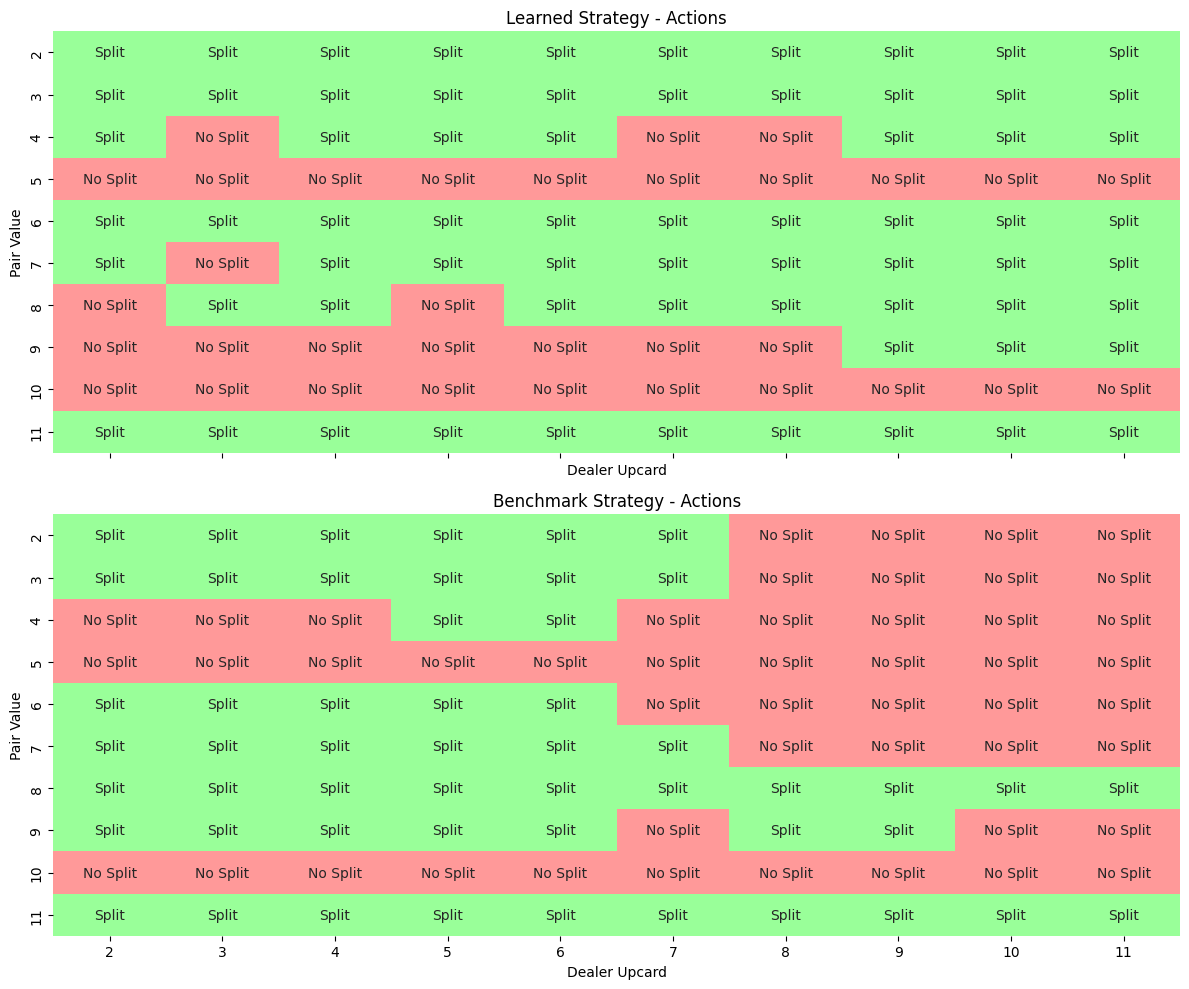

In [22]:
def visualize_q_tables(q_table_split_avg, benchmark_split):
    """
    Visualize the actions (split or not split) for the learned strategy and the benchmark strategy.
    """
    # Create a DataFrame for the learned strategy
    learned_data = []
    for state_key, actions in q_table_split_avg.items():
        best_action = max(actions, key=actions.get)  # Get the action with the highest Q-value
        learned_data.append({
            'Pair Value': state_key[0],
            'Dealer Upcard': state_key[1],
            'Action': 'Split' if best_action == 1 else 'No Split'
        })
    learned_df = pd.DataFrame(learned_data)

    # Create a DataFrame for the benchmark strategy
    benchmark_data = []
    for state_key, actions in benchmark_split.items():
        best_action = max(actions, key=actions.get)  # Get the action with the highest Q-value
        benchmark_data.append({
            'Pair Value': state_key[0],
            'Dealer Upcard': state_key[1],
            'Action': 'Split' if best_action == 1 else 'No Split'
        })
    benchmark_df = pd.DataFrame(benchmark_data)

    # Merge the two DataFrames on Pair Value and Dealer Upcard
    merged_df = pd.merge(learned_df, benchmark_df, on=['Pair Value', 'Dealer Upcard'], suffixes=('_Learned', '_Benchmark'))

    # Set up the figure and axes
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot the learned strategy
    learned_pivot = merged_df.pivot(index='Pair Value', columns='Dealer Upcard', values='Action_Learned')
    sns.heatmap(
        learned_pivot.replace({'Split': 1, 'No Split': 0}),
        annot=learned_pivot,
        fmt="",
        cmap=sns.color_palette(["#FF9999", "#99FF99"]),
        ax=axes[0],
        cbar=False
    )
    axes[0].set_title('Learned Strategy - Actions')
    
    # Plot the benchmark strategy
    benchmark_pivot = merged_df.pivot(index='Pair Value', columns='Dealer Upcard', values='Action_Benchmark')
    sns.heatmap(
        benchmark_pivot.replace({'Split': 1, 'No Split': 0}),
        annot=benchmark_pivot,
        fmt="",
        cmap=sns.color_palette(["#FF9999", "#99FF99"]),
        ax=axes[1],
        cbar=False
    )
    axes[1].set_title('Benchmark Strategy - Actions')
    
    plt.xlabel('Dealer Upcard')
    plt.ylabel('Pair Value')
    
    plt.tight_layout()
    plt.show()

visualize_q_tables(q_table_split_avg, basic_split_strat)


In [23]:
#export the learned strategy to a csv file
os.chdir("..")
os.chdir("strategies")
# q_table_split_avg_df = pd.DataFrame(q_table_split_avg).T
# q_table_split_avg_df.to_csv("q_table_split_avg.csv", index=True, header=True)
q_table_split_avg_df = pd.DataFrame({
    'Pair Value': [state[0] for state in q_table_split_avg.keys()],
    'Dealer Upcard': [state[1] for state in q_table_split_avg.keys()],
    'Split': [q_table_split_avg[state][1] for state in q_table_split_avg.keys()],
    'No Split': [q_table_split_avg[state][0] for state in q_table_split_avg.keys()],
    'Action': ['Split' if q_table_split_avg[state][1] > q_table_split_avg[state][0] else 'No Split' for state in q_table_split_avg.keys()]
})
q_table_split_avg_df.to_csv("split_strat.csv", index=False, header=True)

In [24]:
# # create the benchmark strategy csv file
# benchmark_split_df = pd.DataFrame({
#     'Pair Value': [state[0] for state in benchmark_split.keys()],
#     'Dealer Upcard': [state[1] for state in benchmark_split.keys()],
#     'Split': [benchmark_split[state][1] for state in benchmark_split.keys()],
#     'No Split': [benchmark_split[state][0] for state in benchmark_split.keys()],
#     'Action': ['Split' if benchmark_split[state][1] > benchmark_split[state][0] else 'No Split' for state in benchmark_split.keys()]
# })
# benchmark_split_df.to_csv("basic_split_strat.csv", index=False, header=True)